#  Прогнозирование заказов такси

<h2> (Тема №12: Временные ряды) <a class="tocSkip"> </h2>

<a name="1"></a>
## 1. Содержание

[1. Содержание](#1)

[2. Описание проекта](#2)

*    [2.1. Цель проекта](#21)
*    [2.2. Задачи проекта](#22)
*    [2.3. Описание данных](#23)
*    [2.4. План работы](#24)

[3. Подготовка данных](#3)

*    [3.1. Изучение данных](#31)
*    [3.2. Ресемплирование](#32)
*    [3.3. Создание признаков](#33)
*    [3.4. Вывод](#34)

[4. Анализ данных](#4)

*    [4.1. Тренд](#41)
*    [4.2. Сезонность](#42)
*    [4.3. Вывод](#43)

[5. Обучение моделей](#5)

*    [5.1. Разделение данных на выборки](#51)
*    [5.2. Функция для обучения моделей](#52)
*    [5.3. `LinearRegression`](#53)
*    [5.4. `RandomForestRegressor`](#54)
*    [5.5. `LGBMRegressor`](#55)
*    [5.6. `CatBoostRegressor`](#56)
*    [5.7. Сравнение моделей](#57)
*    [5.8. Вывод](#58)

[6. Тестирование лучшей модели](#6)

*    [6.1. Качество модели](#61)
*    [6.2. Зависимость количества заказов от времени](#62)
*    [6.3. Вывод](#63)

[7. Общий вывод](#7)

<a name="2"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
## 2. Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

<a name="21"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
### 2.1. Цель проекта

Провести исследование с целью построения модели машинного обучения, которая поможет предсказать количество заказов такси на следующий час.

Результаты исследования позволят привлечь больше водителей в период пиковой нагрузки.

<a name="22"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
### 2.2. Задачи проекта

1. Изучить данные.
2. Подготовить данные.
3. Проанализировать данные.
4. Построить и обучить модели.
5. Протестировать лучшую модель.
6. Написать общий вывод.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

<a name="23"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
### 2.3. Описание данных

Предоставлены исторические данные о заказах такси в аэропортах. 

Данные находятся в файле `taxi.csv`. 

Количество заказов (целевой признак) находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<a name="24"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
### 2.4. План работы

1. Изучим данные.
2. Выполним ресемплирование данных по одному часу.
3. Проанализируем данные.
4. Сделаем тестовую выборку размером 10% от исходных данных.
5. Обучим разные модели с различными гиперпараметрами. 
6. Проверим данные на тестовой выборке и сделаем выводы.

<a name="3"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
## 3. Подготовка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, \
TimeSeriesSplit, train_test_split
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose

RANDOM_STATE = 12345
TEST_SIZE = 0.1

<a name="31"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
### 3.1. Изучение данных

Загрузим данные. Установим признак `datetime` в качестве индекса в датафрейме `data` и изменим тип данных `datetime` с `object` на `datetime64`.

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    try:
        data = pd.read_csv(r'C:/Users/lorad/OneDrive/Documents/Моя папка/Data Science/Курсы/'
                            'Яндекс.Практикум. Специалист по Data Science/Проектная работа/'
                            '12. Временные ряды/taxi.csv', index_col=[0], parse_dates=[0])
    except:
        try:
            data = pd.read_csv(r'D:/Юлия/Data Science/Курсы/'
                                'Яндекс.Практикум. Специалист по Data Science/Проектная работа/'
                                '12. Временные ряды/taxi.csv', index_col=[0], parse_dates=[0])
        except:
            data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/'
            '2PACX-1vRscfgBpogQtmdItzCjwG_beePiBpJke8m5cWdOSJMl5V3yBSw74KfX8ZbCneba1Ztm3NzYEEO47oBK/'
                               'pub?gid=502090791&single=true&output=csv', 
                               index_col=[0], parse_dates=[0])

In [3]:
data.shape

(26496, 1)

In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Отсортируем индекс датафрейма с помощью атрибута `is_monotonic` и проверим, в хронологическом ли порядке расположены даты и время.

In [6]:
data.sort_index(inplace=True)
print(data.index.is_monotonic_increasing)
data.info()

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


<a name="32"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
### 3.2. Ресемплирование

Выполним ресемплирование данных по одному часу и вызовем функцию `.sum()` для агрегации значений.

In [7]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<a name="33"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
### 3.3. Создание признаков

Напишем функцию `make_features()` для создания признаков: 
- календарные признаки (день недели `dayofweek` и час `hour`), 
- отстающие значения (`lag_1`, `lag_2`), 
- скользящее среднее (`rolling_mean`).

In [8]:
def make_features(data, max_lag, rolling_mean_size):
    
    result = data.copy()
    
    result['dayofweek'] = data.index.dayofweek
    result['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        result['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    result['rolling_mean'] = data['num_orders'].shift().\
    rolling(rolling_mean_size).mean()
    
    return result

Применим функцию `make_features()` к датафрейму `data` с размером отставания `max_lag`=2 и с размером окна скользящего среднего `rolling_mean_size`=24. Получим новый датасет.

In [9]:
data_plus = make_features(data, 2, 24)
data_plus

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,NaN
...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,164.875000
2018-08-31 20:00:00,154,4,20,136.0,207.0,167.541667
2018-08-31 21:00:00,159,4,21,154.0,136.0,168.041667


<a name="34"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
### 3.4. Вывод

В разделе [**Подготовка данных**](#3.-Подготовка-данных) были выполнены следующие задачи:
1. данные прочитаны, в качестве индекса мы установили признак `datetime` и изменили тип данных `datetime` с `object` на `datetime64`;
2. выполнено ресемплирование данных по одному часу;
3. созданы новые признаки: календарные признаки (день недели и час), отстающие значения, скользящее среднее.

В результате выполнения задач этого раздела было выявлено следующее:
- даты и время в датафрейме расположены в хронологическом порядке.

**В проекте решается задача регрессии.**

Таким образом, данные подготовлены для обучения моделей.

<a name="4"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
## 4. Анализ данных

Проанализируем временной ряд. У нас есть данные за полгода - с 1 марта по 31 августа 2018 года. Посмотрим тренд за этот период, а также сезонные изменения в пределах недели и дня.

<a name="41"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
### 4.1. Тренд

Чтобы не мешала периодичность более высокого порядка, ресемплируем данные по дням.

In [10]:
decomposed_day = seasonal_decompose(data.resample('1D').sum())

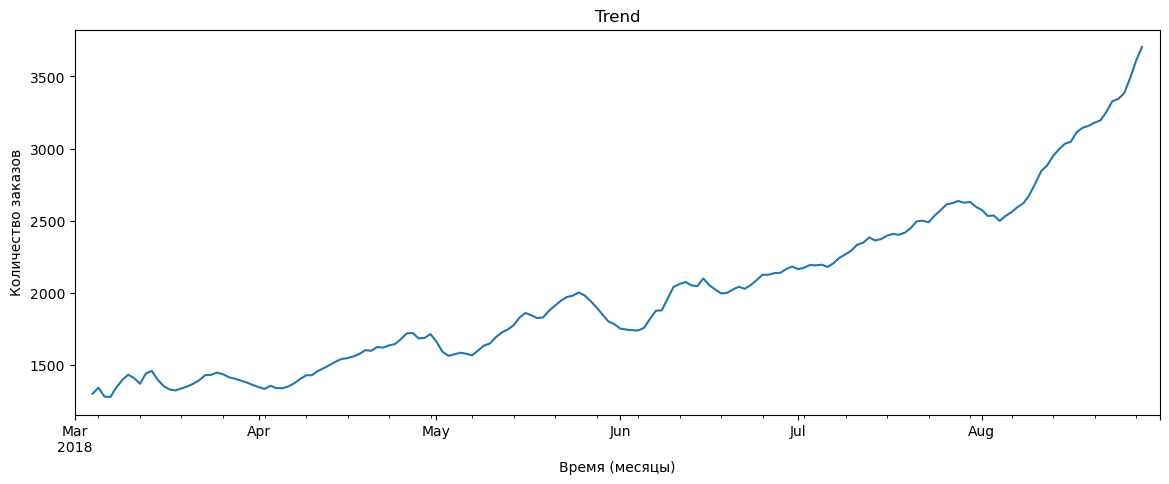

In [11]:
plt.figure(figsize=(14, 5))
decomposed_day.trend.plot(title='Trend')
plt.xlabel("Время (месяцы)")
plt.ylabel('Количество заказов')
plt.show()

На графике хорошо прослеживается рост числа заказов такси в аэропорт за полгода.

<a name="42"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
### 4.2. Сезонность

Посмотрим, как изменяется число заказов такси в течение **недели**.

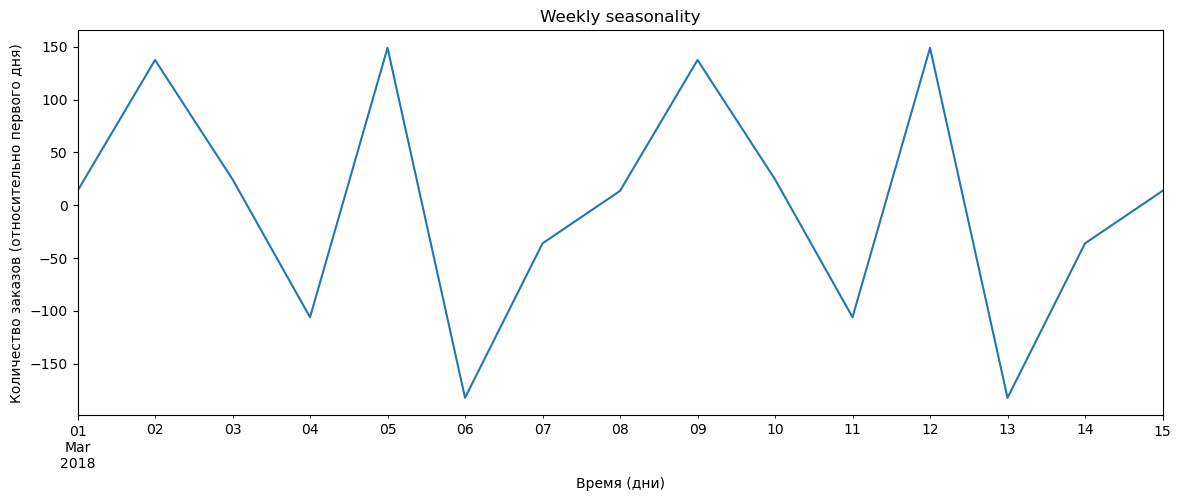

In [12]:
plt.figure(figsize=(14, 5))
decomposed_day.seasonal['2018-03-01':'2018-03-15'].plot(title='Weekly seasonality')
plt.xlabel("Время (дни)")
plt.ylabel('Количество заказов (относительно первого дня)')
plt.show()

Здесь видны пики во вторник и пятницу. То есть больше всего заказов такси в аэропорт приходится на начало и конец рабочей недели.

Посмотрим, как изменяется число заказов такси в течение **дня**. Для этого воспользуемся ресемплингом по часам.

In [13]:
decomposed_hour = seasonal_decompose(data)

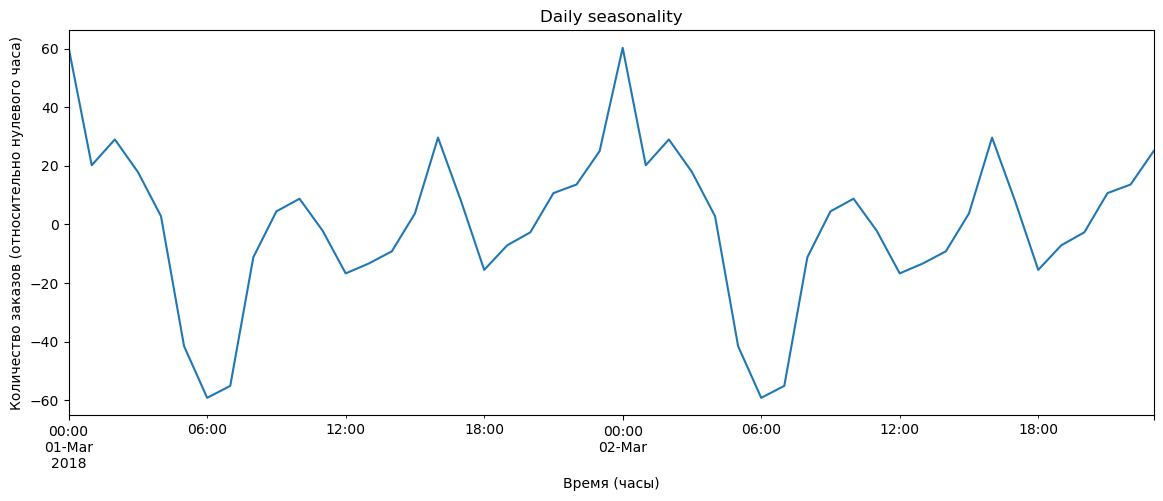

In [14]:
plt.figure(figsize=(14, 5))
decomposed_hour.seasonal['2018-03-01':'2018-03-2'].plot(title='Daily seasonality')
plt.xlabel("Время (часы)")
plt.ylabel('Количество заказов (относительно нулевого часа)')
plt.show()

На графике видно, что самое непопулярное время - 6:00. Затем в течение дня наблюдаются несколько пиков: в ~10:00, в ~16:00 и самое загруженное время - в ~00:00.

<a name="43"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
### 4.3. Вывод

В разделе [**Анализ данных**](#4.-Анализ-данных) были выполнены следующие задачи:
1. проанализирован тренд за полугодовой период с 1 марта по 31 августа 2018 года;
2. проанализированы сезонные изменения в пределах недели и дня.

В результате выполнения задач этого раздела было выявлено следующее:
1. в течение всего полугодового периода с 1 марта по 31 августа 2018 года прослеживается рост числа заказов такси в аэропорт;
2. в пределах недели: больше всего заказов такси в аэропорт приходится на вторник и пятницу;
3. в пределах дня: самое непопулярное время - 6:00. Затем в течение дня наблюдаются несколько пиков: в ~10:00, в ~16:00 и самое загруженное время - в ~00:00.

<a name="5"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
## 5. Обучение моделей

Обучим разные модели с различными гиперпараметрами. Сделаем тестовую выборку размером 10% от исходных данных.

<a name="51"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
### 5.1. Разделение данных на выборки

Разделим данные на обучающую и тестовую выборки в соотношении 9:1.

Перемешивать выборки в задаче прогнозирования временного ряда нельзя, поэтому укажем аргумент `shuffle` (с англ. «перетасовывать») равным `False`, чтобы разделить данные корректно. Данные обучающей выборки должны предшествовать данным тестовой. Иначе тестирование модели будет некорректным: модель не должна обучаться на данных из будущего.

In [15]:
data_plus.dropna(inplace=True)

X = data_plus.drop('num_orders', axis=1)
y = data_plus['num_orders']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, test_size=TEST_SIZE)

In [16]:
print('Размеры выборок:')
print(f'train: {len(X_train)} - {len(X_train)/len(data):.0%}')
print(f'test: {len(X_test)} - {len(X_test)/len(data):.0%}')

Размеры выборок:
train: 3952 - 89%
test: 440 - 10%


<a name="52"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
### 5.2. Функция для обучения моделей

Обучим четыре модели: линейную регрессию (*Linear Regression*), случайный лес (*Random Forest*), градиентные бустинги *LightGBM* и *CatBoost*. Качество моделей оценим кросс-валидацией `GridSearchCV` с метрикой *RMSE* и разделением на фолды `TimeSeriesSplit`.

Напишем функцию `fit_model()`, которая подбирает лучшую модель с помощью `GridSearchCV`, выводит метрику *RMSE* и параметры лучшей модели.

Зададим параметры для кроссвалидации: `n_splits` - количество фолдов.

In [17]:
tscv = TimeSeriesSplit(n_splits=4)

In [18]:
def fit_model(estimator, param_grid, X_train, y_train):
    model = GridSearchCV(estimator=estimator,
                         param_grid=param_grid,
                         n_jobs=-1,
                         cv=tscv,
                         scoring='neg_root_mean_squared_error'
                         )

    model.fit(X_train, y_train)
    best_rmse = abs(round(model.best_score_, 1))

    print(f'Best RMSE: {best_rmse}')
    print(f'Best params: {model.best_params_}')

    return model.best_estimator_, best_rmse

<a name="53"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
### 5.3. `LinearRegression`

Построим модель **линейной регрессии *Linear Regression***. Используем `Pipeline` для автоматизации предварительных преобразований данных перед обучением модели.

In [19]:
%%time

lr_estimator = Pipeline([
    ('lr', LinearRegression())
])

scores = cross_val_score(lr_estimator, 
                         X_train, 
                         y_train, 
                         scoring='neg_root_mean_squared_error', 
                         cv=tscv)

rmse_lr = abs(scores.mean())
print(f'RMSE: {rmse_lr:.1f}')

RMSE: 32.1
CPU times: total: 141 ms
Wall time: 39 ms


Модель линейной регрессии **`LinearRegression`** имеет значение метрики оценки качества ***RMSE = 32.1***.

<a name="54"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
### 5.4. `RandomForestRegressor`

Построим модель **случайного леса *Random Forest*** для задачи регрессии.

In [20]:
%%time

rf_param_grid = {
    # максимальная глубина дерева
    'max_depth': list(range(5, 12, 2)), 
    # количество деревьев
    'n_estimators': list(range(50, 121, 10))
}

rf_best_model = fit_model(
    estimator=RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    param_grid=rf_param_grid,
    X_train=X_train,
    y_train=y_train
)

Best RMSE: 26.4
Best params: {'max_depth': 11, 'n_estimators': 120}
CPU times: total: 4.83 s
Wall time: 13.4 s


Лучшая модель случайного леса **`RandomForestRegressor`** имеет значение метрики оценки качества ***RMSE = 26.4*** при следующих параметрах:
- глубина дерева: `max_depth` = 11;
- количество деревьев: `n_estimators` = 120.

<a name="55"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
### 5.5. `LGBMRegressor`

Построим модель **градиентного бустинга *LightGBM*** для задачи регрессии.

In [21]:
%%time

lgbm_param_grid = {
    # максимальная глубина дерева
    'max_depth': range(4, 9, 2), 
    # количество деревьев (итераций)
    'n_estimators': range(100, 201, 50),
    # коэффициент скорости обучения (размер шага градиентного спуска)
    'learning_rate': [0.01, 0.05, 0.1]
}

lgbm_best_model = fit_model(
    estimator=LGBMRegressor(random_state=RANDOM_STATE, 
                            n_jobs=-1,
                            # отключение прогресса обучения модели
                            verbose=-1),
    param_grid=lgbm_param_grid,
    X_train=X_train,
    y_train=y_train
)

Best RMSE: 26.0
Best params: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100}
CPU times: total: 1.12 s
Wall time: 7.67 s


Лучшая модель градиентного бустинга **`LGBMRegressor`** имеет значение метрики оценки качества ***RMSE = 26.0*** при следующих параметрах:
- глубина дерева: `max_depth` = 8;
- количество деревьев (итераций): `n_estimators` = 100;
- коэффициент скорости обучения (размер шага градиентного спуска): `learning_rate` = 0.05.

<a name="56"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
### 5.6. `CatBoostRegressor`

Построим модель **градиентного бустинга *CatBoost*** для задачи регрессии.

`CatBoostRegressor` создает временные файлы для обучения. Чтобы не появлялась ошибка о том, что по указанными путям у `CatBoostRegressor` нет доступа к созданию файлов, укажем в модели параметр `allow_writing_files=False`.

In [22]:
%%time

catboost_param_grid = {
    # глубина дерева
    'depth': range(2, 12, 3), 
    # количество итераций
    'iterations': range(250, 301, 50), 
    # коэффициент скорости обучения (размер шага градиентного спуска)
    'learning_rate': [0.05, 0.1, 0.15], 
}

catboost_best_model = fit_model(
    estimator=CatBoostRegressor(random_state=RANDOM_STATE, 
                                verbose=False, 
                                allow_writing_files=False),
    param_grid=catboost_param_grid,
    X_train=X_train,
    y_train=y_train
)

Best RMSE: 26.3
Best params: {'depth': 5, 'iterations': 300, 'learning_rate': 0.05}
CPU times: total: 6.28 s
Wall time: 51.8 s


Лучшая модель градиентного бустинга **`CatBoostRegressor`** имеет значение метрики оценки качества ***RMSE = 26.3*** при следующих параметрах:
- глубина дерева: `depth` = 5;
- количество итераций: `iterations` = 300;
- коэффициент скорости обучения (размер шага градиентного спуска): `learning_rate` = 0.05.

<a name="57"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
### 5.7. Сравнение моделей

Выведем значения метрики *RMSE* различных моделей в виде таблицы.

In [23]:
table = pd.DataFrame([
    ['LinearRegression', f'{rmse_lr:.1f}'],
    ['RandomForestRegressor', f'{rf_best_model[1]:.1f}'],
    ['LGBMRegressor', f'{lgbm_best_model[1]:.1f}'],
    ['CatBoostRegressor', f'{catboost_best_model[1]:.1f}']
],
columns=['model', 'RMSE'])

table

,model,RMSE
0,LinearRegression,32.1
1,RandomForestRegressor,26.4
2,LGBMRegressor,26.0
3,CatBoostRegressor,26.3


В качестве лучшей модели выберем модель градиентного бустинга **`LGBMRegressor`**, так как значение метрики ***RMSE = 26.0*** у нее мешьше остальных.

<a name="58"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
### 5.8. Вывод

В разделе [**Обучение моделей**](#5.-Обучение-моделей) были выполнены следующие задачи:
1. Данные разделены на выборки.
2. Написана функция `fit_model()`, которая подбирает лучшую модель с помощью `GridSearchCV`, выводит метрику *RMSE* и параметры лучшей модели.
3. Обучены четыре модели (`LinearRegression`, `RandomForestRegressor`, `LGBMRegressor` и `CatBoostRegressor`) с различными гиперпараметрами.
4. Выведены значения метрики *RMSE* различных моделей в виде таблицы.


В результате выполнения задач этого раздела было выявлено следующее:
- Лучшая модель градиентного бустинга **`LGBMRegressor`** **на обучающей выборке** имеет значение метрики оценки качества ***RMSE = 26.0*** при следующих параметрах:
    - глубина дерева: `max_depth` = 8;
    - количество деревьев (итераций): `n_estimators` = 100;
    - коэффициент скорости обучения (размер шага градиентного спуска): `learning_rate` = 0.05.

<a name="6"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
## 6. Тестирование лучшей модели

<a name="61"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
### 6.1. Качество модели

Проверим качесто выбранной модели **градиентного бустинга `LGBMRegressor` на тестовой выборке**.

In [24]:
pred = lgbm_best_model[0].predict(X_test)

# параметр squared=False возвращает метрику RMSE
rmse = mean_squared_error(y_test, pred, squared=False) 
print(f'RMSE на тестовой выборке: {rmse:.1f}')

RMSE на тестовой выборке: 44.8


Лучшая модель градиентного бустинга **`LGBMRegressor`** на тестовой выборке имеет значение метрики оценки качества ***RMSE = 44.8***.

<a name="62"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
### 6.2. Зависимость количества заказов от времени

Для тестовой выборки построим график зависимости истинных и предсказанных значений количества заказов от времени.

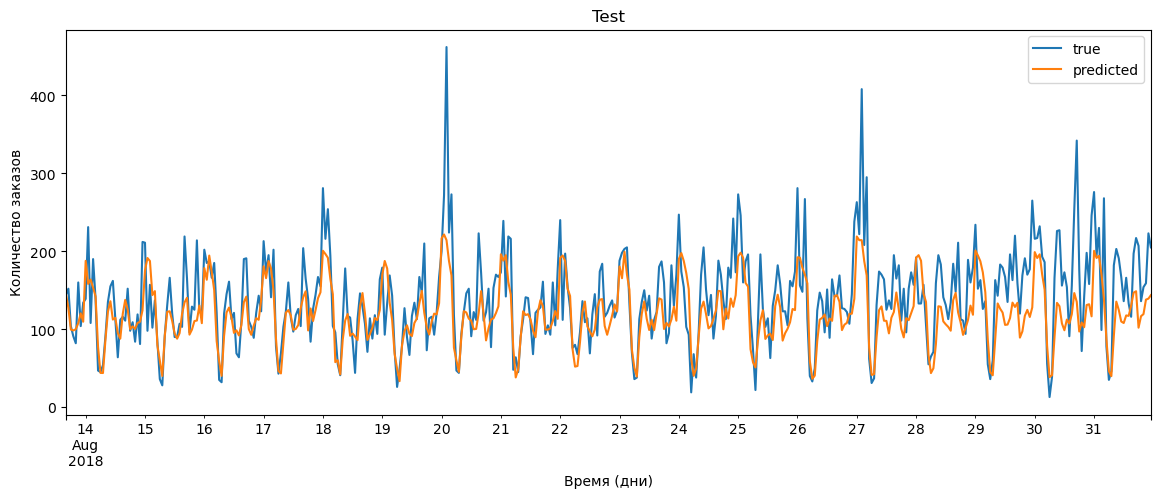

In [25]:
pred = pd.Series(pred, index=y_test.index)

plt.figure(figsize=(14, 5))
y_test.plot(label='true', title='Test')
pred.plot(label='predicted')
plt.legend()
plt.xlabel("Время (дни)")
plt.ylabel('Количество заказов')
plt.show()

На графике видно, что зависимости истинных и предсказанных значений количества заказов от времени имеют схожий характер.

<a name="63"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
### 6.3. Вывод

В разделе [**Тестирование лучшей модели**](#6.-Тестирование-лучшей-модели) были выполнены следующие задачи:
1. проверено качесто выбранной модели **`LGBMRegressor`** на тестовой выборке;
2. для тестовой выборки построен график зависимости истинных и предсказанных значений количества заказов от времени.

В результате выполнения задач этого раздела было выявлено следующее:
1. лучшая модель градиентного бустинга **`LGBMRegressor`** на тестовой выборке имеет значение метрики оценки качества ***RMSE = 44.8***;
2. значение метрики ***RMSE*** **на тестовой выборке** не превышает ***48***, что соответствует изначальному требованию в условии задачи проекта.

<a name="7"></a> <div style="text-align: right">[Cодержание](#1.-Содержание)</div>
## 7. Общий вывод

Проведено исследование с целью построения модели машинного обучения, которая поможет предсказать количество заказов такси на следующий час.

Результаты исследования позволят привлечь больше водителей в период пиковой нагрузки.

Входные данные: исторические данные о заказах такси в аэропортах за полгода - с 1 марта по 31 августа 2018 года.

В ходе исследования удалось получить следующие результаты **на обучающей выборке**:

1. Модель линейной регрессии **`LinearRegression`** имеет значение метрики оценки качества ***RMSE = 32.1***.


2. Лучшая модель случайного леса **`RandomForestRegressor`** имеет значение метрики оценки качества ***RMSE = 26.4*** при следующих параметрах:
    - глубина дерева: `max_depth` = 11;
    - количество деревьев: `n_estimators` = 120.


3. Лучшая модель градиентного бустинга **`LGBMRegressor`** имеет значение метрики оценки качества ***RMSE = 26.0*** при следующих параметрах:
    - глубина дерева: `max_depth` = 8;
    - количество деревьев (итераций): `n_estimators` = 100;
    - коэффициент скорости обучения (размер шага градиентного спуска): `learning_rate` = 0.05.
   

4. Лучшая модель градиентного бустинга **`CatBoostRegressor`** имеет значение метрики оценки качества ***RMSE = 26.3*** при следующих параметрах:
    - глубина дерева: `depth` = 5;
    - количество итераций: `iterations` = 300;
    - коэффициент скорости обучения (размер шага градиентного спуска): `learning_rate` = 0.05.
   

Исходя из полученных результатов, можно сделать следующие **выводы**:

1. лучшая модель градиентного бустинга **`LGBMRegressor` на тестовой выборке** имеет значение метрики оценки качества ***RMSE = 44.8***;
2. значение метрики ***RMSE*** на тестовой выборке не превышает ***48***, что соответствует изначальному требованию в условии задачи проекта.
   
**Общие рекомендации:**

Специалистам, занимающимся регулированием количества водителей в различные периоды нагрузки, можно рекомендовать использовать полученную модель **`LGBMRegressor`**.